<hr style="border-width:4px;border-color:coral" />

# Solving the 2d heat equation

<hr style="border-width:4px;border-color:coral" />

This notebook gives you an introduction to solving the 2d heat equation using the finite difference approach.  

* <a href="#heat2d">Heat equation in two dimensions</a>

* <a href="#heatcode">Pseudo-code for the 2d heat equation</a>

* <a href="#plotting">Plot the initial conditions</a>

* <a href="#timesteps">Plot the time steps</a>

This note book also provides a template for how to plot data from your heat equation. This code will work for either serial or parallel output.

<a id="heat2d"></a>

<hr style="border-width:4px; border-color:coral"></hr>

The non-dimensional heat equation in two dimensions is given by 

\begin{equation*}
q_t = \nabla^2 q
\end{equation*}

where now $q(x,y,t)$ is a function of two spatial variables $\mathbf x = (x,y)$ and $\nabla^2 q$ is the 2d Laplacian given by 

\begin{equation*}
\nabla^2 q \equiv q_{xx} + q_{yy}
\end{equation*}

In analogy with the 1d example shown above, we solve this problem in the domain $[0,1]\times [0,1]$ over a time interval $[0,T]$.  As in the 1d case, we will apply no-flux boundary conditions on each edge of our unit square domain. 

\begin{equation*}
q_x(0,y,t) = q_x(1,y,t) = q_y(x,0,t) = q_y(x,1,t) = 0
\end{equation*}

The Method-of-Lines approach described above extends to 2d in a very natural way.  The discrete mesh is now a two-dimensional mesh in points $\mathbf x_{ij} \equiv (x_i,y_j)$ on the domain $[0,1] \times [0,1]$ using $N_x$ mesh cells in the x-direction and $N_y$ mesh cells in the y direction.  For a square domain, it makes sense to choose $N_x = N_y$, although in what follows we do not make this assumption.

The general mesh consisting of points $(x_i,y_j)$ is given by 

\begin{equation*}
\begin{aligned}
x_i & = i\Delta x, \qquad i = 0,1,2, ..., N_x \\
y_j & = j\Delta y, \qquad j = 0,1,2, ..., N_y
\end{aligned}
\end{equation*}

where $\Delta x = 1/N_x$ and $\Delta y = 1/N_y$. 

Our semi-discrete system in 2d in terms of functions $Q_{ij}(t) \approx q(x_i,y_j,t)$ is given by

\begin{equation}
Q_{ij}'(t) =  \frac{Q_{i-1,j}(t) - 2 Q_{ij}(t) + Q_{i+1,j}(t)}{(\Delta x)^2} + 
\frac{Q_{i,j-1}(t) - 2 Q_{ij}(t) + Q_{i,j+1}(t)}{(\Delta y)^2}
\end{equation}

A critical difference between 1d and 2d is that in 2d, our time step restriction is given by

\begin{equation*}
(\Delta t)_{stable} < \frac{\min[(\Delta x)^2,(\Delta y)^2]}{4}
\end{equation*}

Notice the factor of 4 rather than 2.   

<a id="heatcode"></a>

<hr style="border-width:4px"></hr>

## Pseudo-code for solving the 2d heat equation using Forward Euler 

Below is a pseudo-code for a basic time stepping scheme for the 2d heat equation on the domain $[0,1] \times [0,1]$ over the time span $t \in [0,T]$.  

    dx = 1/Nx;
    dy = 1/Ny;
    dx2 = dx*dx;
    dy2 = dy*dy;

    dsmin = (dx < dy) ? dx : dy;
    dt_stable = 0.9*dsmin^2/4;
    M = ceil(T/dt_stable) + 1;
    dt = T/M;

    /* Initialize q */
    for(i = -1; i <= Nx+1; i++)
    {
        for(j = -1; j <= Ny+1; j++)
        {
            x = i*dx;
            y = j*dy;
            qn[i][j] = init(x,y);
        }
    }

    /* Time step to get the solution in time */
    for(n = 0; n <= M; n++)
    {
        /* Apply no-flux boundary conditions */
        for(j = 0; j <= Ny; j++)
        {        
            qn[-1][j] = qn[1][j]
            qn[Nx+1][j] = qn[Nx-1][j]
        }
        for(i = 0; i <= Nx; i++)
        {        
            qn[i][-1] = qn[i][1]
            qn[i][Ny+1] = qn[i][Ny-1]
        }

        /* Update each qn[i][j] */
        for(i = 0; i <= Nx; i++)
        {
            for(j = 0; j <= Ny; j++)
            {
                qxx = (qn[i-1][j] - 2*qn[i][j] + qn[i+1][j])/dx2;
                qyy = (qn[i][j-1] - 2*qn[i][j] + qn[i][j+1])/dy2;
                qnp1[i][j] = qn[i][j] + dt*(qxx + qyy);
            }
        }
        
        /* Store time step every M/nout time steps .... */
        
        qn = qpn1;     
    }

<hr style="border-width:2px, border-style:solid">

If you would like more details on the above, see 

[Finite Difference Methods for Ordinary and Partial Differential Equations: Steady-State and Time-Dependent Problems](https://epubs.siam.org/doi/book/10.1137/1.9780898717839).  

Using this link,  you will be able to download the book for free through the BSU libraries.   

In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## Running your heat example

The code below is designed to take three arguments : the number of mesh cells in x and by directions, and the number of output files to produce.  For example

    $ heat2d 64 64 40
    
will run on a mesh with $N_x=N_y=64$ mesh cells in each direction and will create 40 output files at times $t_0=0, t_1, t_2, ..., t_{39}=T$. 

In [2]:
%%bash

rm -rf heat2d

gcc -o heat2d -O2 heat2d_serial.c

heat2d 256 256 40

## Read meta data

Meta data is stored by the executable and read in here.  It is a good idea to check that everything that was read in is correct and agrees with what you expect.  

In [3]:
# Open file for reading; use binary mode
fout = open("heat2d.out","rb")

# Read meta data
dt_meta = dtype([('Nx','int32'),('Ny','int32'),('ax','d'),('bx','d'), \
                 ('ay','d'),('by','d'),('M','int32')])
d = fromfile(fout,dtype=dt_meta, count=1)[0]

# create dictionary containing meta data
parms = dict(zip(dt_meta.fields,d))

# Print meta data from dictionary
print("Mesh cell dimensions : ({Nx:2d},{Ny:2d})".format(**parms))
print("")
print("Domain : [{ax:g},{bx:g}] x [{ay:g},{by:g}]".format(**parms))
print("")
print("Total number of time steps : {M:d}".format(**parms))
print("")

# Assign values in tuple directly (for use below)
Nx,Ny,ax,bx,ay,by,M = d

# Read solution data and count number of output steps.  This should match number
# set by the user in call to `heat2d`
dt_heat = dtype([('t','d'),('q','d',(Nx+1)*(Ny+1))])  
data = fromfile(fout,dtype=dt_heat)
Mout = len(data) # Number of time steps output.
print("Number of output steps : {:d}".format(Mout))

# Close file
fout.close()

Mesh cell dimensions : (256,256)

Domain : [-1,1] x [-1,1]

Total number of time steps : 6900

Number of output steps : 40


## Create the 2d mesh

We create a 2d mesh needed for plotting. 

In [4]:
xe = linspace(ax,bx,Nx+1)
ye = linspace(ay,by,Ny+1)

dx = (bx-ax)/Nx
dy = (by-ay)/Ny

[xm,ym] = meshgrid(xe,ye)

<a id="plotting"></a>

<hr style="border-width:4px; border-color:coral"></hr>

## Plot the initial conditions

<hr style="border-width:4px; border-color:coral"></hr>

<IPython.core.display.Javascript object>


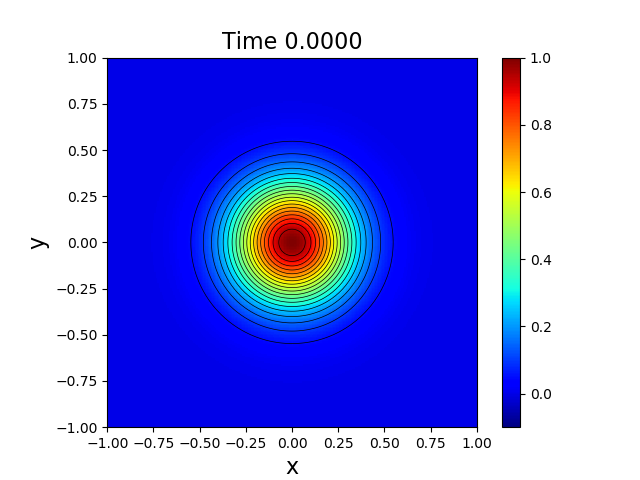

In [5]:
# Plot initial conditions
figure(1)
clf()

set_cmap('jet')

q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,vmin=-0.1,vmax=1)

cv = linspace(0,1,21)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

gca().set_aspect(1)

title('Time {:0.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16)

colorbar(mesh)

show()

In [ ]:
figure(1)
#savefig('heat_0.png', dpi=Nx, facecolor=None, edgecolor=None,
#        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)

<a id="timesteps"></a>

<hr style="border-width:4px; border-color:coral"></hr>

## Plot the solution in time

<hr style="border-width:4px; border-color:coral"></hr>

<IPython.core.display.Javascript object>


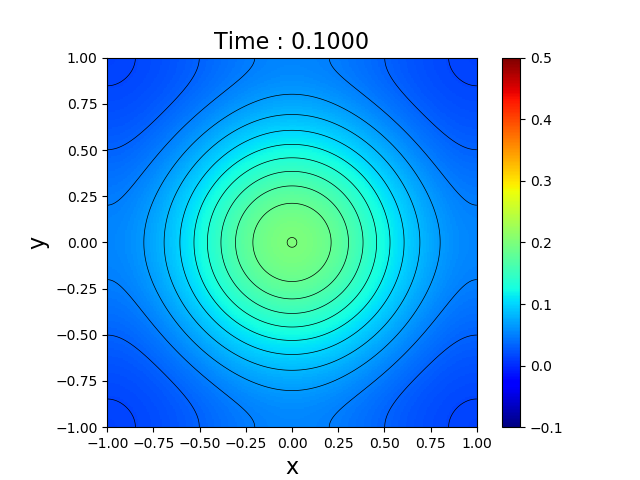

qmax =   2.00281992e-01
qmin =   1.46439357e-02


In [6]:
# Plot initial solution and store handle
fig = figure(2)
clf()

q = reshape(data[0][1],(Nx+1,Ny+1))
mesh = pcolormesh(xm,ym,q,shading='flat',vmin=-0.1,vmax=0.5)
    
# Set up contour lines
cv = linspace(0,0.5,31)
cv = cv[1:]   # avoid 0 contours
cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

# Add title, axis labels, etc
htitle = title('Time : {:.4f}'.format(0),fontsize=16)
xlabel('x',fontsize=16)
ylabel('y', fontsize=16) 

colorbar(mesh)

# Make axis square
gca().set_aspect(1)

# Refresh plot
fig.canvas.draw()     

pause(0.25)

for n in range(0,Mout):

    t = data[n][0]
    
    q = reshape(data[n][1],(Nx+1,Ny+1))
    #q = data[n][1]
    mesh.set_array(q[:-1,:-1].ravel())

    # Plot contour lines
    for c in cont.collections:
        c.remove()
    cont = contour(xm,ym,q,colors='k',levels=cv,linewidths=0.5)

    # Update title with new time
    htitle.set_text('Time : {:.4f}'.format(t))

    # Make axis square
    gca().set_aspect(1)

    # Refresh plot
    fig.canvas.draw()        
    
    pause(0.1)
    
print("qmax = {:16.8e}".format(q.max()))
print("qmin = {:16.8e}".format(q.min()))

In [ ]:
figure(2)
#savefig('heat_1.png', dpi=Nx, facecolor=None, edgecolor=None,
#        format='png',transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None)